In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import array
from scipy.interpolate import RegularGridInterpolator
import sys
import math
from skmisc.loess import loess

In [2]:
def main(day):
    # print('in')
    fn      = '/glade/work/geethma/research/data_cygnss/2019/cyg.ddmi.s201902'+f'{day:02d}'+'-003000-e201902'+f'{day:02d}'+'-233000.l3.grid-wind.a30.d31.nc'
    # cyg.ddmi.s20190226-003000-e20190226-233000.l3.grid-wind.a30.d31
    dsi     = nc.Dataset(fn)
    # ds.append(dsi)
    lons	= dsi.variables['lon'][:]           #size=1800 #Range is 0.1 .. 359.9 #resolution=0.2
    lats	= dsi.variables['lat'][:]        #size=400 #Range is -39.9 .. 39.9 #resolution=0.2
    u		= dsi.variables['wind_speed'][:,:,:]    #float wind_speed(time, lat, lon) #units = "m s-1"
    globals()['time']    = dsi.variables['time'][:]          #size=24
    dsi.close
##############
    fna     = '/glade/work/geethma/research/data_amsr2/2019/RSS_AMSR2_ocean_L3_daily_2019-02-'+f'{day:02d}'+'_v08.2.nc'
    # RSS_AMSR2_ocean_L3_daily_2019-02-09_v08.2
    dsa     = nc.Dataset(fna)
    lonsa   = dsa.variables['lon'][:]          #size=1440  #Range is 0.125 .. 359.875 #resolution=0.25
    latsa	= dsa.variables['lat'][:]          #size=720 #Range is -89.875 .. 89.875 #resolution=0.25
    ua      = dsa.variables['wind_speed_LF'][:,:,:]  #float32 wind_speed_LF(pass, lat, lon)
    timea   = dsa.variables['time'][:,:,:]            #(pass, lat, lon) shape=(2,720,1440)
    passa   = dsa.variables['pass'][:]
    raina   = dsa.variables['rain_rate'][:,:,:]
    dsa.close
# ############
# ##############
    # x = lons
    x = np.array(lons)
    y = np.array(lats)
    z = np.array(time)
    # zg, yg, xg = np.meshgrid(z,y, x, indexing='ij', sparse=True)
    # data = u
    globals()['my_interpolate'] = RegularGridInterpolator((z,y,x), u, method='nearest')  #a function [0:23,-39.9:39.9,0.1:359]
    xa = np.array(lonsa)
    ya = np.array(latsa)
    za = np.array(passa)
    # zga, yga, xga = np.meshgrid(za, ya, xa, indexing='ij', sparse=True)
    # dataa = np.array(ua)
    globals()['my_interpolate_a'] = RegularGridInterpolator((za,ya,xa), ua, method='nearest')#a function [1:2,-89.9:89.9,0.1:359]
    globals()['my_interpolate_t'] = RegularGridInterpolator((za,ya,xa), timea, method='nearest')
    globals()['my_interpolate_r'] = RegularGridInterpolator((za,ya,xa), raina, method='nearest') #rain_rate
    

    ##########
    
    

In [3]:
day = 6
main(day)

In [ ]:
k = 11
for day in range(k,k+2):
    main(day)

    am = []
    cyg = []
    r = []
    bias = []
    cT = []
    aT = []
    longt = []
    latit = []
    for i in range(0,24): #time_cyg (0,24)
        for j in range(1,3): #pass (1,3)
            for k in np.arange(-39,40,0.5): #lats(-39,40)
                for l in np.arange(1,360,0.5): #lons(1,360)
                    pt  = [i,k,l]
                    pta = [j,k,l]
                    cygn = my_interpolate(pt)
                    amsr = my_interpolate_a(pta)
                    amT = my_interpolate_a(pta)
                    rr = my_interpolate_r(pta)
                    #print(cygn)
                    if cygn>1 and amsr>1 and cygn<50 and amsr<50:
                        t = abs(time[i] - amT)
                        if t<=0.5:
                          b = (cygn[0]-amsr[0])
                          bias.append(b)
                          r.append(rr[0])
                          cyg.append(cygn[0])
                          am.append(amsr[0])
                          cT.append(time[i])
                          aT.append(amT[0])
                          longt.append(l)
                          latit.append(k)

    save(day)


In [5]:
def save(day):
    np.savez_compressed('/glade/work/geethma/research/npzfilesn/2019_/january/new_02'+f'{day:02d}'+'2019', cw=cyg, aw=am, b=bias, ar=r, cT=cT, aT=aT, lon=longt, lat=latit) #u10_monthdateyear.npz


In [6]:
save(day)

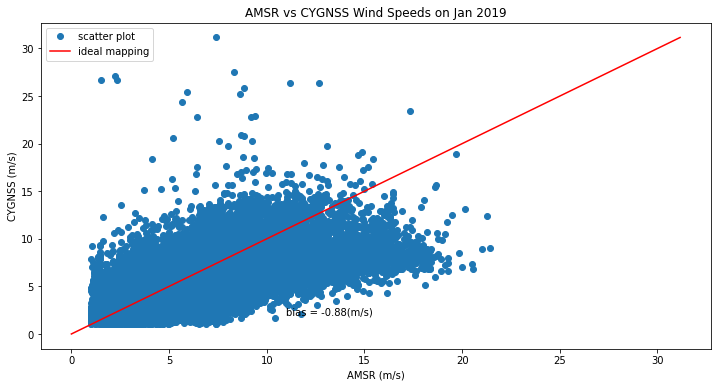

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import glob
#####data in npz npzfiles
#####cw=cyg, aw=am, b=bias, ar=r, cT=cT, aT=aT, lon=longt, lat=latit
fig = plt.figure(figsize=(12,6))
fn = glob.glob('/glade/work/geethma/research/npzfilesn/2019_/january/new*npz')  #u10*npz
fn = np.array(fn)
awf=[]
cwf = []
bf = []
# print(fn)
for i in range(0,len(fn)): #len(fn)
    # print (i)
    d = np.load(fn[i])
    aw = np.array(d['aw'])
    cw = np.array(d['cw'])
    # bi = np.array(d['b'])
    ##################
    for i in range(0,len(aw)):
        awf.append(aw[i])
        cwf.append(cw[i])
        bf.append(cw[i]-aw[i])
        
plt.plot(awf, cwf, "o", label='scatter plot')

bm = np.round(np.mean(bf),2) #mean bias

x = [0,max(cwf)]
y = [0,max(cwf)]
plt.plot(x,y,c='r',label='ideal mapping')
plt.legend()
plt.text(11, 2, 'bias = '+str(bm)+'(m/s)')

plt.title('AMSR vs CYGNSS Wind Speeds on Jan 2019')
plt.ylabel('CYGNSS (m/s)')
plt.xlabel('AMSR (m/s)')
plt.show()
# plt.savefig('/glade/work/geethma/research/npzfilesn/2019/january2/plots/plot_amVScyg.png') #/plots
#"/glade/work/geethma/research/npzfilesn/2019/jann/u10_01072019.npz"


In [11]:
print(max(bf),min(bf))

25.170618 -13.703764


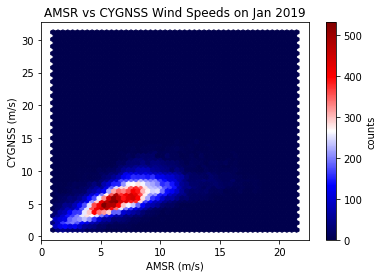

In [12]:
import numpy as np
import matplotlib.pyplot as plt

xmin = min(awf)
xmax = max(awf)
ymin = min(cwf)
ymax = max(cwf)

fig= plt.figure()
# fig.subplots_adjust(hspace=0.5, left=0.07, right=0.93)
# ax = axs[0]
hb = plt.hexbin(awf, cwf, gridsize=50, cmap='Blu')
# plt.axis([xmin, xmax, ymin, ymax])
plt.title('AMSR vs CYGNSS Wind Speeds on Jan 2019')
plt.ylabel('CYGNSS (m/s)')
plt.xlabel('AMSR (m/s)')
cb = fig.colorbar(hb)
cb.set_label('counts')
plt.show()


# ax = axs[1]
# hb = ax.hexbin(x, y, gridsize=50, bins='log', cmap='inferno')
# ax.axis([xmin, xmax, ymin, ymax])
# ax.set_title("With a log color scale")
# cb = fig.colorbar(hb, ax=ax)
# cb.set_label('log10(N)')

# plt.show()

Text(0.5, 0, 'AMSR (m/s)')

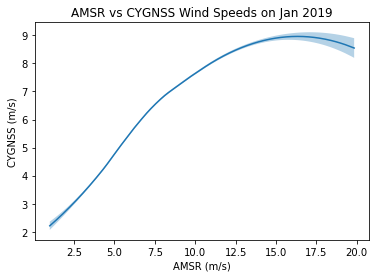

In [3]:
x = np.array(awf)
y = np.array(cwf)
ind = np.argsort(x)
xx = np.sort(x)
yy = y[ind]

l = loess(xx,yy)
l.fit()
pred = l.predict(xx, stderror=True)
conf = pred.confidence()

lowess = pred.values
ll = conf.lower
ul = conf.upper

# plt.plot(xx, yy, '+')
plt.plot(xx, lowess, label='MODEL FIT')
plt.fill_between(xx,ll,ul,alpha=.33)
plt.title('AMSR vs CYGNSS Wind Speeds on Jan 2019')
plt.ylabel('CYGNSS (m/s)')
plt.xlabel('AMSR (m/s)')

In [4]:
z = np.polyfit(awf,cwf, 1)
poly = np.poly1d(z)
zz = poly(awf)
    
    # fig = plt.figure()
#     plt.plot(x,y, label='MAC-LWP + MERRA2')
# plt.plot(awf, zz)
# print(poly)

In [5]:
from scipy import stats
bin_means, bin_edges, binnumber = stats.binned_statistic(awf, cwf, 'mean', bins=100)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2
# plt.figure()
# # plt.hist(samples, bins=500, density=True, histtype='stepfilled',
#          # alpha=0.2, label='histogram of data')
# plt.plot(bin_centers[:], bin_means[:], 'r.', label='binned data')
# plt.title('AMSR vs CYGNSS Wind Speeds on Jan 2019')
# plt.ylabel('CYGNSS (m/s)')
# plt.xlabel('AMSR (m/s)')
# # plt.show()
# plt.legend(fontsize=10)
# z = np.polyfit(awf,cwf, 1)
# poly = np.poly1d(z)
# zz = poly(awf)
    
# #     # fig = plt.figure()
# # #     plt.plot(x,y, label='MAC-LWP + MERRA2')
# plt.plot(awf, zz)
# print(poly)
# # plt.savefig('/glade/work/geethma/research/output/windVsMmean.png')
# plt.show()

Text(11, 2, 'cygnss - AMSR = -1.22(m/s)')

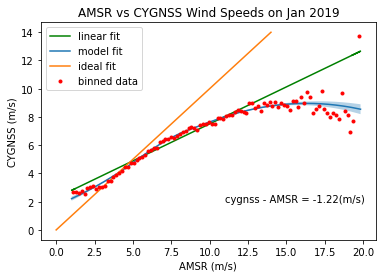

In [7]:
plt.plot(awf, zz, label='linear fit',color='g')
plt.plot(xx, lowess, label='model fit')
plt.plot([0,14],[0,14],label='ideal fit')
plt.plot(bin_centers[:], bin_means[:], 'r.', label='binned data')
plt.fill_between(xx,ll,ul,alpha=.33)
plt.title('AMSR vs CYGNSS Wind Speeds on Jan 2019')
plt.ylabel('CYGNSS (m/s)')
plt.xlabel('AMSR (m/s)')
plt.legend(fontsize=10)
plt.text(11, 2, 'cygnss - AMSR = '+str(bm)+'(m/s)')

Text(0.5, 0, 'AMSR (m/s)')

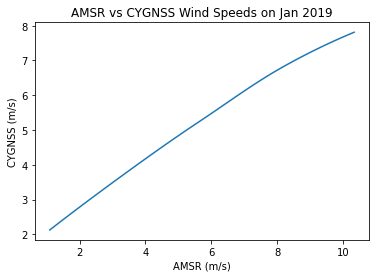

In [13]:
x = np.array(bin_centers[:])
y = np.array(bin_means[:])
ind = np.argsort(x)
xx = np.sort(x)
yy = y[ind]

l = loess(xx,yy)
l.fit()
pred = l.predict(xx, stderror=True)
conf = pred.confidence()

lowess = pred.values
ll = conf.lower
ul = conf.upper

# plt.plot(xx, yy, '+')
plt.plot(xx, lowess, label='MODEL FIT')
plt.fill_between(xx,ll,ul,alpha=.33)
plt.title('AMSR vs CYGNSS Wind Speeds on Jan 2019')
plt.ylabel('CYGNSS (m/s)')
plt.xlabel('AMSR (m/s)')

In [18]:
print(conf)

In [17]:
from scipy import stats
x_pdf=stats.maxwell.pdf(bf)

Text(0.5, 0, 'bias (m/s)')

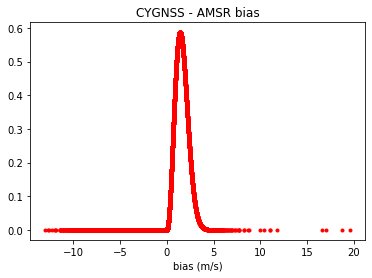

In [18]:
fig = plt.figure()
plt.plot(bf, x_pdf, 'r.', label='bias pdf')
plt.title('CYGNSS - AMSR bias')
plt.xlabel('bias (m/s)')
# plt.ylabel('AMSR (m/s)')